## Depth of upwelling in two-canyon runs

* All experiments have 3 runs to get a mean curve (except aug01, I eliminated run that does weird things).
* Parameters can be found on google drive sheet lab_speadsheets/exp_list
* Using low pass filter

In [1]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
%matplotlib inline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools

In [2]:
sns.set_style('white')
sns.set_context('notebook')

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(15, color=col, linestyle=':')
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [4]:
# Information for all runs is stored in experiment_dictionaries.py
lib_path = os.path.abspath('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts') # Add absolute path to my python scripts
sys.path.append(lib_path)

import experiment_dictionaries as exdic

In [5]:
exp_dicts = [exdic.T01,exdic.T02,exdic.T03,exdic.T04,exdic.T05,
             exdic.T06,exdic.T07,exdic.T08,exdic.T09,exdic.T10,
             exdic.T11,exdic.T12, exdic.DYE02, exdic.T13b,exdic.T14,
             exdic.T15,exdic.T16,exdic.T17]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']
exp_Norder = [exdic.T02,exdic.T03,exdic.T04,exdic.T05,exdic.T01,
             exdic.DYE02,exdic.T12,exdic.T11,exdic.T07,exdic.T06,
             exdic.T08,exdic.T10, exdic.T09]

Text(0,0.5,'$Z_{lab}$ / cm')

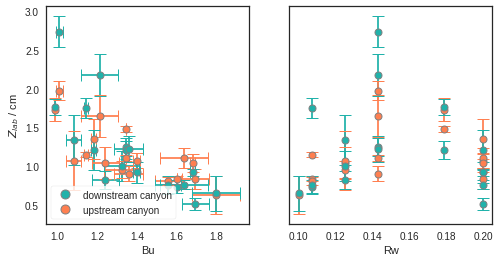

In [6]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho1 = np.zeros(len(exp['run_files']))
    delta_rho2 = np.zeros(len(exp['run_files']))
    error1 = np.zeros(len(exp['run_files']))
    error2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
            err1 = ((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        max_ind1 = np.argmax((ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)))
        max_ind2 = np.argmax((ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)))
        error1[ii] = 1000*(err1[max_ind1]+err1[0])
        error2[ii] = 1000*(err2[max_ind2]+err2[1])    
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
    Z1 = np.nanmean(100*(g/rho0)*(delta_rho1/N**2)) #cm
    Z2 = np.nanmean(100*(g/rho0)*(delta_rho2/N**2)) #cm
    std1 = np.nanstd(100*(g/rho0)*(delta_rho1/N**2)) #cm
    std2 = np.nanstd(100*(g/rho0)*(delta_rho2/N**2)) #cm
    errZ1 = np.nanmean(100*(g/rho0)*(error1/N**2))
    errZ2 = np.nanmean(100*(g/rho0)*(error2/N**2))
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    
    if std1 > errZ1:
        yerror1 = std1
    else:
        yerror1 = errZ1
    
    if std2 > errZ2:
        yerror2 = std2
    else:
        yerror2 = errZ2
        
    sca = ax1.errorbar(Bu,Z1,yerr=yerror1,xerr=stdBu,
                       marker='o',color='coral', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca = ax1.errorbar(Bu,Z2,yerr=yerror2,xerr=stdBu,
                       marker='o',color='lightseagreen', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Rw,Z1,yerr=yerror1,
                        marker='o',color='coral',
                        markeredgecolor='0.5',
                        markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Rw,Z2,yerr=yerror2,
                        marker='o',color='lightseagreen', 
                        markeredgecolor='0.5', 
                        markeredgewidth=1,capsize=6) 

        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   ]
ax1.legend(handles=legend_elements, loc=3,frameon=True )
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
#plt.savefig('figures/Z_Ro_Rw_twocan_error_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

Text(0,0.5,'$Z_{lab}$ / cm')

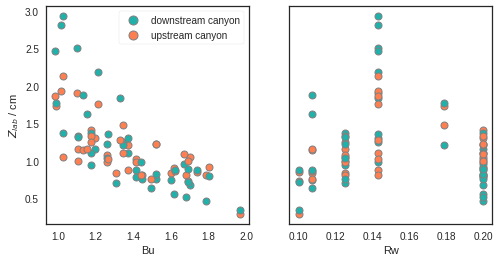

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        
        Z1 = 100*(g/rho0)*(delta_rho1/N**2) #cm
        Z2 = 100*(g/rho0)*(delta_rho2/N**2) #cm
        
        sca = ax1.plot(Bu,Z1,
                       'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca = ax1.plot(Bu,Z2,
                       'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca2 = ax2.plot(Rw,Z1,
                        'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        sca2 = ax2.plot(Rw,Z2,
                        'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 

        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   ]
ax1.legend(handles=legend_elements, loc=0,frameon=True )
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
#plt.savefig('figures/Z_Ro_Rw_twocan_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

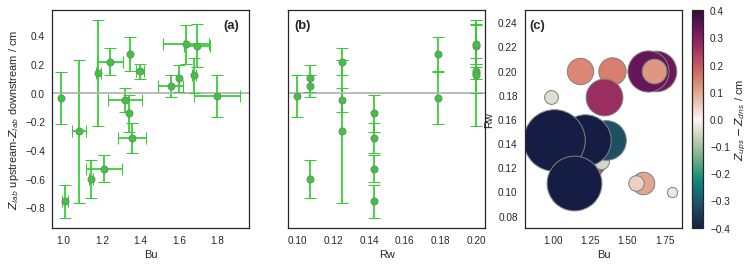

In [8]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.axhline(0, color='0.7')
ax2.axhline(0, color='0.7')

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    Z1 = np.zeros(len(exp['run_files']))
    Z2 = np.zeros(len(exp['run_files']))
    errZ1 = np.zeros(len(exp['run_files']))
    errZ2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
            err1 = ((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        max_ind1 = np.argmax((ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)))
        max_ind2 = np.argmax((ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)))
        error1 = 1000*(err1[max_ind1]+err1[0])
        error2 = 1000*(err2[max_ind2]+err2[1])    
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
        Z1[ii] = (100*(g/rho0)*(delta_rho1/N[ii]**2)) #cm
        Z2[ii] = (100*(g/rho0)*(delta_rho2/N[ii]**2)) #cm
        errZ1[ii] = (100*(g/rho0)*(error1/N[ii]**2))
        errZ2[ii] = (100*(g/rho0)*(error2/N[ii]**2))
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    Zdif = np.nanmean(Z1-Z2)
    std_dif = np.nanstd(Z1-Z2)
    err_Zdif = np.nanmean((errZ1**2+errZ2**2)**0.5)
    
    if std_dif > err_Zdif:
        yerror = std_dif
    else:
        yerror = err_Zdif
    
    sca = ax1.errorbar(Bu,Zdif,yerr=yerror,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,Zdif,yerr=yerror,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=5000*(abs(Zdif)),
                       c=Zdif,
                       cmap = cmo.cm.curl,
                       marker = 'o',
                       vmax=0.4,
                       vmin=-0.4,
                       edgecolors='0.5',
                       linewidth=1, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$Z_{ups}-Z_{dns}$ / cm')
ax3.set_ylim(0.07,0.25)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_ylabel('Rw')
ax3.set_xlabel('Bu')
ax1.set_ylabel(r'$Z_{lab}$ upstream-$Z_{lab}$ downstream / cm')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/difference_Z_Bu_Rw_twocan_error_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

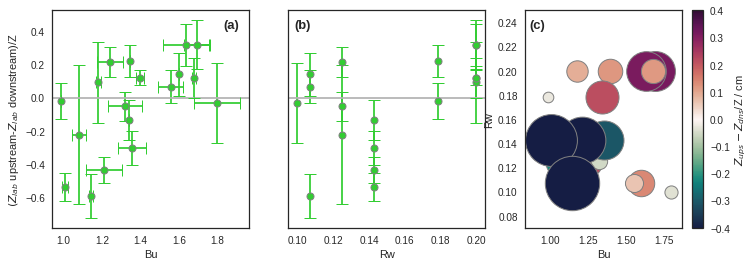

In [9]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.axhline(0, color='0.7')
ax2.axhline(0, color='0.7')

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    Z1 = np.zeros(len(exp['run_files']))
    Z2 = np.zeros(len(exp['run_files']))
    Z_HA2013 = np.zeros(len(exp['run_files']))
    errZ1 = np.zeros(len(exp['run_files']))
    errZ2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
            err1 = ((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        max_ind1 = np.argmax((ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)))
        max_ind2 = np.argmax((ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)))
        error1 = 1000*(err1[max_ind1]+err1[0])
        error2 = 1000*(err2[max_ind2]+err2[1])    
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N[ii]
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N[ii])/(f*((Fw/Rl)**0.5))
        Z_HA2013[ii] = 100*Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        Z1[ii] = (100*(g/rho0)*(delta_rho1/N[ii]**2)) #cm
        Z2[ii] = (100*(g/rho0)*(delta_rho2/N[ii]**2)) #cm
        errZ1[ii] = (100*(g/rho0)*(error1/N[ii]**2))
        errZ2[ii] = (100*(g/rho0)*(error2/N[ii]**2))
    
    Z_HA = np.nanmean(Z_HA2013)
    stdHA = np.nanstd(Z_HA2013)
    
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*(W*100)))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*(W*100)))
    Rw = exp["U"]/(exp["fo"]*(W*100))
    Zdif = np.nanmean(Z1-Z2)
    std_dif = np.nanstd(Z1-Z2)
    err_Zdif = np.nanmean((errZ1**2+errZ2**2)**0.5)
    if std_dif > err_Zdif:
        yerror = std_dif
    else:
        yerror = err_Zdif
    
    sca = ax1.errorbar(Bu,Zdif/Z_HA,yerr=yerror/Z_HA,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,Zdif/Z_HA,yerr=yerror/Z_HA,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=5000*(abs(Zdif/Z_HA)),
                       c=Zdif/Z_HA,
                       cmap = cmo.cm.curl,
                       marker = 'o',
                       vmax=0.4,
                       vmin=-0.4,
                       edgecolors='0.5',
                       linewidth=1, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$Z_{ups}-Z_{dns}$/Z / cm')
ax3.set_ylim(0.07,0.25)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_ylabel('Rw')
ax3.set_xlabel('Bu')
ax1.set_ylabel(r'$(Z_{lab}$ upstream-$Z_{lab}$ downstream)/Z')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/difference_Z_norm_Bu_Rw_twocan_error_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

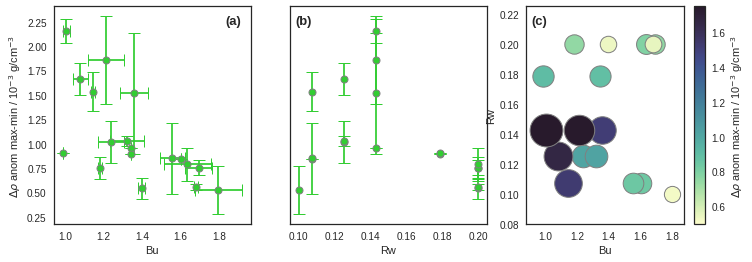

In [10]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho_maxmin = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
            
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho = 1000*(ctools.butter_lowpass_filter((dens2[0:2400]-dens2[0])-(dens1[0:2400]-dens1[0]),f0-(f0/8), fs, order=5)) # kg/m^3
        delta_rho_maxmin[ii] = np.max(delta_rho)-np.min(delta_rho)
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    delta_rho_mean = np.nanmean(delta_rho_maxmin)
    delta_rho_std = np.nanstd(delta_rho_maxmin)
    
    sca = ax1.errorbar(Bu,delta_rho_mean,yerr=delta_rho_std,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,delta_rho_mean,yerr=delta_rho_std,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=500*(abs(delta_rho_mean)),
                       c=delta_rho_mean,
                       cmap = cmo.cm.deep,
                       marker = 'o',
                       vmax=1.75,
                       vmin=0.5,
                       edgecolors='0.5',
                       linewidth=1, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$\Delta \rho$ anom max-min / 10$^{-3}$ g/cm$^{-3}$')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_ylabel('Rw')
ax3.set_xlabel('Bu')

ax1.set_ylabel(r'$\Delta \rho$ anom max-min / 10$^{-3}$ g/cm$^{-3}$')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/difference_max_min_Bu_Rw_twocan_std_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

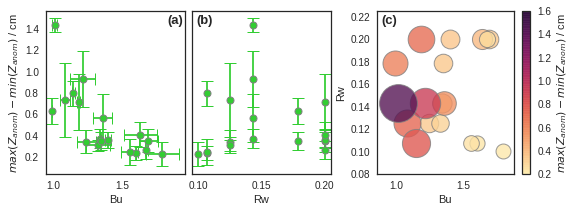

In [11]:
sns.set_style('white')
fig = plt.figure(figsize=(9,3))
gg = gspec.GridSpec(1, 2, wspace=0.2, width_ratios=[2,1.2])
gg1 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gg[0], 
                                    wspace=0.05, width_ratios=[1,1])

ax1 = plt.subplot(gg1[0])
ax2 = plt.subplot(gg1[1])
ax2.set_yticks([], [])
ax3 = plt.subplot(gg[1])
rho0=998.5
g = 9.81

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    Zprobe_dif = np.zeros(len(exp['run_files']))
    error_dif = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    Z_HA2013 = np.zeros(len(exp['run_files']))
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = 1000*ctools.densANK1_09Aug19(P1)
            dens2 = 1000*ctools.densANK2_09Aug19(P2)
            err1 = 1000*((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = 1000*((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = 1000*ctools.densANK1_05Dec19(P1)
            dens2 = 1000*ctools.densANK2_05Dec19(P2)
            err1 = 1000*((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = 1000*((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = 1000*ctools.densANK1_17Aug19(P1)
            dens2 = 1000*ctools.densANK2_17Aug19(P2)
            err1 = 1000*((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = 1000*((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
         
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
             
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
       
        Zprobe1 = (g/rho0)*(ctools.butter_lowpass_filter((dens1[0:2400]-dens1[0]),f0-(f0/8), fs, order=5)/N[ii]**2) # cm
        error_1 = (g/rho0)*(((err1**2+err1[0]**2)**0.5)/N[ii]**2)
        Zprobe2 = (g/rho0)*(ctools.butter_lowpass_filter((dens2[0:2400]-dens2[0]),f0-(f0/8), fs, order=5)/N[ii]**2)
        error_2 = (g/rho0)*(((err2**2+err2[0]**2)**0.5)/N[ii]**2)
        difference = Zprobe1-Zprobe2
        Zprobe_dif[ii] = (np.nanmax(difference)-np.nanmin(difference))
        max_ind = np.argmax((Zprobe1-Zprobe2))
        min_ind = np.argmin((Zprobe1-Zprobe2))
        error_dif[ii] = ((error_1[max_ind]**2+error_2[max_ind]**2)**0.5)
        
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*(W*100)))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*(W*100)))
    Rw = exp["U"]/(exp["fo"]*(W*100))
    Z_mean = np.nanmean(Zprobe_dif)
    Z_std = np.nanstd(Zprobe_dif)
    error_Z = np.nanmean(error_dif)
    
    if Z_std > error_Z:
        yerror = Z_std
    else:
        yerror = error_Z
    
        
    sca = ax1.errorbar(Bu,100*Z_mean,yerr=100*yerror,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,100*Z_mean,yerr=100*yerror,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=1000*(abs(100*Z_mean)),
                       c=100*Z_mean,
                       cmap = cmo.cm.matter,
                       marker = 'o',
                       vmax=1.6,
                       vmin=0.2,
                       edgecolors='0.5',
                       linewidth=1,
                       alpha=0.8, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$max(Z_{anom})-min(Z_{anom})$ / cm')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_ylabel('Rw')
ax3.set_xlabel('Bu')

ax1.set_ylabel(r'$max(Z_{anom})-min(Z_{anom})$ / cm')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/Z_max_min_Bu_Rw_twocan_error_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

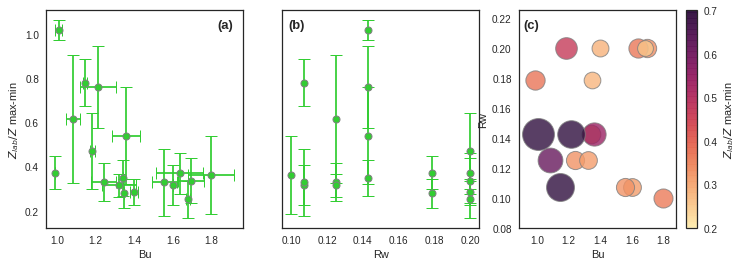

In [12]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    Zprobe_dif = np.zeros(len(exp['run_files']))
    error_dif = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    Z_HA2013 = np.zeros(len(exp['run_files']))
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = 1000*ctools.densANK1_09Aug19(P1)
            dens2 = 1000*ctools.densANK2_09Aug19(P2)
            err1 = 1000*((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = 1000*((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = 1000*ctools.densANK1_05Dec19(P1)
            dens2 = 1000*ctools.densANK2_05Dec19(P2)
            err1 = 1000*((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = 1000*((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = 1000*ctools.densANK1_17Aug19(P1)
            dens2 = 1000*ctools.densANK2_17Aug19(P2)
            err1 = 1000*((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = 1000*((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
         
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N[ii]
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N[ii])/(f*((Fw/Rl)**0.5))
        Z_HA2013[ii] = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
       
        Zprobe1 = (g/rho0)*(ctools.butter_lowpass_filter((dens1[0:2400]-dens1[0]),f0-(f0/8), fs, order=5)/N[ii]**2) # cm
        error_1 = (g/rho0)*(((err1**2+err1[0]**2)**0.5)/N[ii]**2)
        Zprobe2 = (g/rho0)*(ctools.butter_lowpass_filter((dens2[0:2400]-dens2[0]),f0-(f0/8), fs, order=5)/N[ii]**2)
        error_2 = (g/rho0)*(((err2**2+err2[0]**2)**0.5)/N[ii]**2)
        difference = Zprobe1-Zprobe2
        Zprobe_dif[ii] = (np.nanmax(difference)-np.nanmin(difference))/Z_HA2013[ii]
        max_ind = np.argmax((Zprobe1-Zprobe2)/Z_HA2013[ii])
        min_ind = np.argmin((Zprobe1-Zprobe2)/Z_HA2013[ii])
        error_dif[ii] = ((error_1[max_ind]**2+error_2[max_ind]**2)**0.5) /Z_HA2013[ii]
        
    Z_HA = np.nanmean(Z_HA2013)
    stdHA = np.nanstd(Z_HA2013)
    
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*(W*100)))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*(W*100)))
    Rw = exp["U"]/(exp["fo"]*(W*100))
    Z_mean = np.nanmean(Zprobe_dif)
    Z_std = np.nanstd(Zprobe_dif)
    error_Z = np.nanmean(error_dif)
    
    if Z_std > error_Z:
        yerror = Z_std
    else:
        yerror = error_Z
    
        
    sca = ax1.errorbar(Bu,Z_mean,yerr=yerror,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,Z_mean,yerr=yerror,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=1000*(abs(Z_mean)),
                       c=Z_mean,
                       cmap = cmo.cm.matter,
                       marker = 'o',
                       vmax=0.7,
                       vmin=0.2,
                       edgecolors='0.5',
                       linewidth=1,
                       alpha=0.8, 
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'$Z_{lab}/Z$ max-min ')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_ylabel('Rw')
ax3.set_xlabel('Bu')

ax1.set_ylabel(r'$Z_{lab}/Z$ max-min ')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/Z_max_min_Bu_Rw_twocan_error_norm_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

Text(0,0.5,'$Z_{lab}$ upstream-$Z_{lab}$ downstream / cm')

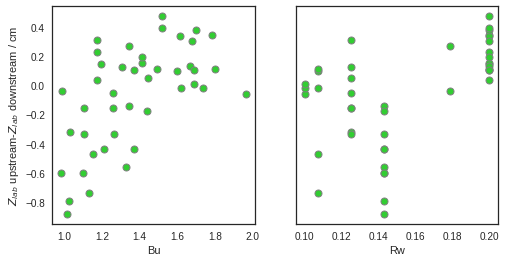

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0=998.5
g = 9.81

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        W = 5 # cm
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        Bu = N*exp["hsb"]/(exp["fo"]*W)
        Rw = exp["U"]/(exp["fo"]*W)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        
        Z1 = 100*(g/rho0)*(delta_rho1/N**2) #cm
        Z2 = 100*(g/rho0)*(delta_rho2/N**2) #cm
        
        sca = ax1.plot(Bu,Z1-Z2,
                       'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
          
        sca2 = ax2.plot(Rw,Z1-Z2,
                        'o',color='limegreen', markeredgecolor='0.5', markeredgewidth=1) 
        
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax1.set_ylabel(r'$Z_{lab}$ upstream-$Z_{lab}$ downstream / cm')
#plt.savefig('figures/difference_Z_Ro_Rw_twocan_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

Text(0.03,0.92,'(c)')

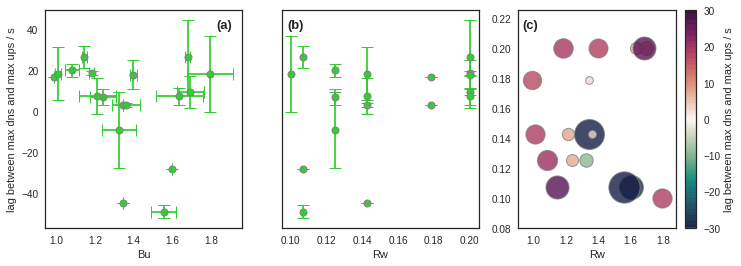

In [14]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

for exp, kk in zip(exp_dicts, range(exp_num)):
    lag = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        rho1 = 1000*(ctools.butter_lowpass_filter((dens1[0:2400]-dens1[0]),f0-(f0/8), fs, order=5)) # kg/m^3
        rho2 = 1000*(ctools.butter_lowpass_filter((dens2[0:2400]-dens2[0]),f0-(f0/8), fs, order=5)) # kg/m^3
        
        lag[ii] = time[np.argmax(rho2)]-time[np.argmax(rho1)]
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
    W = 5 # cm
    Bu = np.nanmean(N*exp["hsb"]/(exp["fo"]*W))
    stdBu = np.nanstd(N*exp["hsb"]/(exp["fo"]*W))
    Rw = exp["U"]/(exp["fo"]*W)
    lag_mean = np.nanmean(lag)
    lag_std = np.nanstd(lag)
    sca = ax1.errorbar(Bu,lag_mean,yerr=lag_std,xerr=stdBu,
                       marker='o',color='limegreen',
                       markeredgecolor='0.5', markeredgewidth=1,capsize=6) 
          
    sca2 = ax2.errorbar(Rw,lag_mean,yerr=lag_std,
                        marker='o',color='limegreen',
                        markeredgecolor='0.5', markeredgewidth=1,capsize=6)
    sca3 = ax3.scatter(Bu,Rw,
                       s=20*(abs(lag_mean)),
                       c=lag_mean,
                       cmap = cmo.cm.curl,
                       marker = 'o',
                       vmax=30,
                       vmin=-30,
                       edgecolors='0.5',
                       linewidth=1,
                       alpha=0.8
                       ) 
cb = plt.colorbar(sca3)
cb.set_label(r'lag between max dns and max ups / s')
ax3.set_ylim(0.08,0.225)
ax1.set_xlabel('Bu')
ax2.set_xlabel('Rw')
ax2.set_yticklabels([])
ax3.set_xlabel('Bu')
ax3.set_xlabel('Rw')

ax1.set_ylabel(r'lag between max dns and max ups / s')
ax1.text(0.87,0.92,'(a)', fontweight='bold', fontsize=13, transform=ax1.transAxes)
ax2.text(0.03,0.92,'(b)', fontweight='bold', fontsize=13, transform=ax2.transAxes)
ax3.text(0.03,0.92,'(c)', fontweight='bold', fontsize=13, transform=ax3.transAxes)
#plt.savefig('figures/lag_Ro_Rw_twocan_std_allruns.pdf', format='pdf', transparent=False, bbox_inches='tight')

the rmse1 is 0.239096
the rmse2 is 0.526453


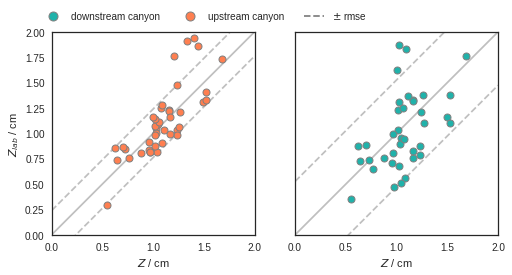

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []


for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        
        Z1 = (g/rho0)*(delta_rho1/N**2) #cm
        Z2 = (g/rho0)*(delta_rho2/N**2) #cm
        
        Z_list1.append(Z1*100)
        Z_list2.append(Z2*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
        sca = ax1.plot(Z_HA2013*100,Z1*100,
                       'o',color='coral', markeredgecolor='0.5', markeredgewidth=1) 
        
        sca = ax2.plot(Z_HA2013*100,Z2*100,
                       'o',color='lightseagreen', markeredgecolor='0.5', markeredgewidth=1) 
        
rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        

ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ rmse'),
                   ]
ax2.legend(handles=legend_elements,ncol=3, bbox_to_anchor=(0.4,1.15))
#plt.savefig('figures/Zlab_vs_Z_HA2013_twocan_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

the rmse1 is 0.202907
the rmse2 is 0.468798


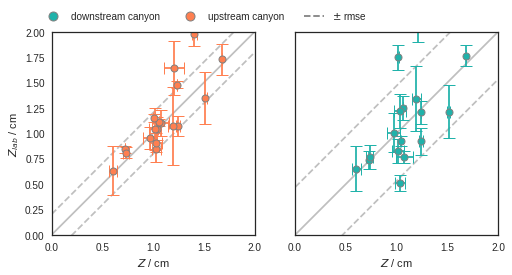

In [16]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho1 = np.zeros(len(exp['run_files']))
    delta_rho2 = np.zeros(len(exp['run_files']))
    error1 = np.zeros(len(exp['run_files']))
    error2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    Z_HA2013 = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
            err1 = ((ctools.errorANK1_09Aug19(P1)*exp["drift_ups"])**2)**0.5 # Fix!       
            err2 = ((ctools.errorANK2_09Aug19(P2)*exp["drift_dns"])**2)**0.5
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
            err1 = ((ctools.errorANK1_17Aug19(P1)*exp["drift_ups"])**2)**0.5        
            err2 = ((ctools.errorANK2_17Aug19(P2)*exp["drift_dns"])**2)**0.5
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        max_ind1 = np.argmax((ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5)))
        max_ind2 = np.argmax((ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5)))
        error1[ii] = 1000*(err1[max_ind1]+err1[0])
        error2[ii] = 1000*(err2[max_ind2]+err2[1])    
        
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N[ii]
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N[ii])/(f*((Fw/Rl)**0.5))
        Z_HA2013[ii] = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
    
    Z_HA = np.nanmean(Z_HA2013)*100
    stdHA = np.nanstd(Z_HA2013)*100
    Z1 = np.nanmean(100*(g/rho0)*(delta_rho1/N**2)) #cm
    Z2 = np.nanmean(100*(g/rho0)*(delta_rho2/N**2)) #cm
    std1 = np.nanstd(100*(g/rho0)*(delta_rho1/N**2)) #cm
    std2 = np.nanstd(100*(g/rho0)*(delta_rho2/N**2)) #cm
    errZ1 = np.nanmean(100*(g/rho0)*(error1/N**2))
    errZ2 = np.nanmean(100*(g/rho0)*(error2/N**2))
      
    if std1 > errZ1:
        yerror1 = std1
    else:
        yerror1 = errZ1
    
    if std2 > errZ2:
        yerror2 = std2
    else:
        yerror2 = errZ2
    
    Z_list1.append(Z1)
    Z_list2.append(Z2)
    Z_HA2013_list.append(Z_HA)
    
    sca = ax1.errorbar(Z_HA,Z1,yerr=yerror1,xerr=stdHA,
                       marker='o',color='coral', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Z_HA,Z2,yerr=yerror2,xerr=stdHA,
                        marker='o',color='lightseagreen',
                        markeredgecolor='0.5',
                        markeredgewidth=1,capsize=6) 

rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        
        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ rmse'),
                   ]
ax2.legend(handles=legend_elements,ncol=3, bbox_to_anchor=(0.4,1.15))
ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
#plt.savefig('figures/Z_vs_Z_HA2013_twocan_error_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

the rmse1 is 0.271871
the rmse2 is 0.616330


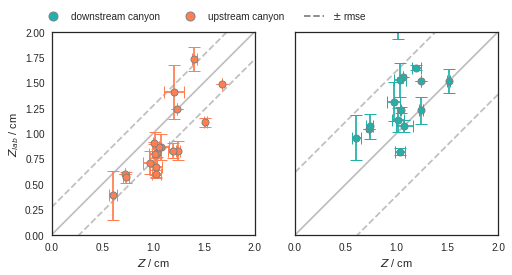

In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

# bias values, subtract from Z_lab
bias_ups = 0.243
bias_dns = -0.305

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

for exp, kk in zip(exp_dicts, range(exp_num)):
    delta_rho1 = np.zeros(len(exp['run_files']))
    delta_rho2 = np.zeros(len(exp['run_files']))
    N = np.ones(len(exp['run_files']))*np.nan
    Z_HA2013 = np.zeros(len(exp['run_files']))
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        
        delta_rho2[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1[ii] = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        if np.isnan(exp["rho_sb"][ii])==True:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N[ii] =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
    
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N[ii]
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N[ii])/(f*((Fw/Rl)**0.5))
        Z_HA2013[ii] = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
    
    Z_HA = np.nanmean(Z_HA2013)*100
    stdHA = np.nanstd(Z_HA2013)*100
    Z1 = np.nanmean(100*(g/rho0)*(delta_rho1/N**2)-bias_ups) #cm
    Z2 = np.nanmean(100*(g/rho0)*(delta_rho2/N**2)-bias_dns) #cm
    std1 = np.nanstd(100*(g/rho0)*(delta_rho1/N**2)-bias_ups) #cm
    std2 = np.nanstd(100*(g/rho0)*(delta_rho2/N**2)-bias_dns) #cm
    
    
    Z_list1.append(Z1)
    Z_list2.append(Z2)
    Z_HA2013_list.append(Z_HA)
    
    sca = ax1.errorbar(Z_HA,Z1,yerr=std1,xerr=stdHA,
                       marker='o',color='coral', 
                       markeredgecolor='0.5', 
                       markeredgewidth=1,capsize=6) 
    sca2 = ax2.errorbar(Z_HA,Z2,yerr=std2,xerr=stdHA,
                        marker='o',color='lightseagreen',
                        markeredgecolor='0.5',
                        markeredgewidth=1,capsize=6) 

rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        
        
legend_elements = [Line2D([0], [0], marker='o', color='w', label='downstream canyon',
                          markerfacecolor='lightseagreen',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='upstream canyon',
                          markerfacecolor='coral',markeredgecolor='0.5',markeredgewidth=1,
                          markersize=9),
                   Line2D([0], [0], linestyle='--',color='0.5', label='$\pm$ rmse'),
                   ]
ax2.legend(handles=legend_elements,ncol=3, bbox_to_anchor=(0.4,1.15))
ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
#plt.savefig('figures/Z_vs_Z_HA2013_twocan_std_bias_allruns.eps', format='eps', transparent=False, bbox_inches='tight')

the rmse1 is 0.239096
the rmse2 is 0.526453


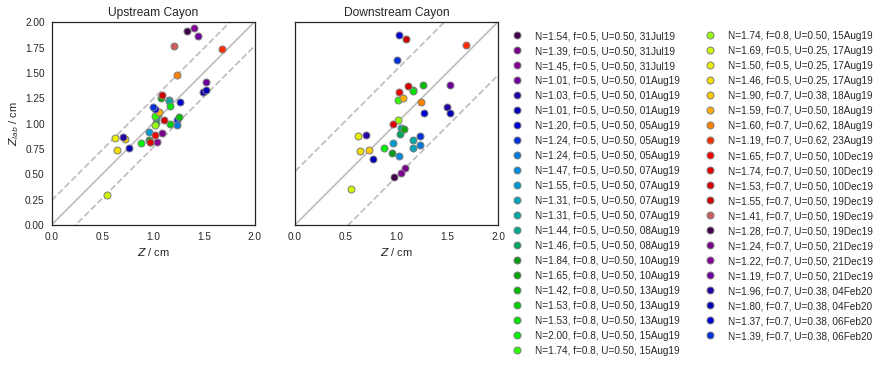

In [19]:
## RUN CELL TWICE
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

rho0 = 998.5
g = 9.81
W = 0.05 # m
L = 0.12 # m

Z_list1 = []
Z_list2 = []
Z_HA2013_list = []

#sns.set_palette(sns.cubehelix_palette(12, start=.5, rot=-.95))
sns.set_palette('nipy_spectral',35)

for exp, kk in zip(exp_dicts, range(exp_num)):
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        elif exp['calibration']=='05Dec19':
            dens1 = ctools.densANK1_05Dec19(P1)
            dens2 = ctools.densANK2_05Dec19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        
        if np.isnan(exp["rho_sb"][ii])==True:
            N =((g/rho0)*((1000*exp["rho_sb"][ii-1]-1000*exp["rho_top"][ii-1])/(exp["hsb"]*0.01)))**0.5
        else:
            N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f = exp["fo"] # rad/s
        U = exp["U"]/100 # m/s
        Hs = exp["hsb"]/100 # m
        s = (0.029-0.005)/(0.215) # (Hsb-Hcoast)/(dist coast to sb) = 0.112
        Dh = (f*L)/N
        Rw = U/(f*W)
        Rl = U/(f*L)
        Fw = Rw/(0.9+Rw)
        Se = (s*N)/(f*((Fw/Rl)**0.5))
        Z_HA2013 = Dh*((1.8*((Fw*Rl)**0.5)*(1-0.42*Se))+0.05)
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        fs = len(time)/np.max(time) # Sampling frequency in Hz
        delta_rho2 = 1000*(np.max(ctools.butter_lowpass_filter(dens2[0:2400]-dens2[0],f0-(f0/8), fs, order=5))) # kg/m^3
        delta_rho1 = 1000*(np.max(ctools.butter_lowpass_filter(dens1[0:2400]-dens1[0],f0-(f0/8), fs, order=5))) # kg/m^3
        
        Z1 = (g/rho0)*(delta_rho1/N**2) #cm
        Z2 = (g/rho0)*(delta_rho2/N**2) #cm
        
        Z_list1.append(Z1*100)
        Z_list2.append(Z2*100)
        Z_HA2013_list.append(Z_HA2013*100)
        
        sca = ax1.plot(Z_HA2013*100,Z1*100,
                       'o', markeredgecolor='0.5', markeredgewidth=1, 
                       ) 
        
        sca = ax2.plot(Z_HA2013*100,Z2*100,
                       'o', markeredgecolor='0.5', markeredgewidth=1,
                      label='N=%1.2f, f=%1.1f, U=%1.2f, %s' %(N,exp["fo"],exp["U"], exp["date"])) 
        
rmse1 = (mean_squared_error(Z_HA2013_list, Z_list1))**0.5
rmse2 = (mean_squared_error(Z_HA2013_list, Z_list2))**0.5
print('the rmse1 is %f' %rmse1)        
print('the rmse2 is %f' %rmse2)        

ax1.set_xlabel('$Z$ / cm')
ax2.set_xlabel('$Z$ / cm')
ax1.set_ylabel(r'$Z_{lab}$ / cm')
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.set_aspect(1)
ax2.set_xlim(0,2)
ax2.set_ylim(0,2)
ax2.set_aspect(1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse1, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20), '-', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)+rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax2.plot(np.linspace(0,2,20),np.linspace(0,2,20)-rmse2, '--', color='0.5', alpha = 0.5,zorder=1)
ax1.set_title('Upstream Cayon')
ax2.set_title('Downstream Cayon')
ax2.legend(ncol=2,bbox_to_anchor=(1,1))